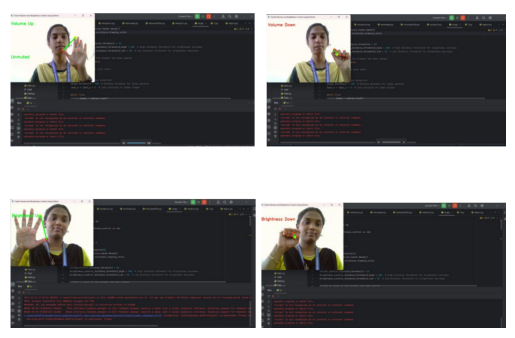

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import pyautogui
import screen_brightness_control as sbc
import webbrowser
import os

# Initialize webcam
webcam = cv2.VideoCapture(0)

# Initialize MediaPipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
draw = mp.solutions.drawing_utils

# Constants
volume_threshold = 50
brightness_threshold_high = 100
brightness_threshold_low = 50
swipe_threshold = 100
is_muted = False
browser_opened = False

x1 = y1 = x2 = y2 = last_x = last_y = 0

while True:
    success, image = webcam.read()
    if not success:
        break

    frame_height, frame_width, _ = image.shape
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = hands.process(rgb_image)
    hand_landmarks = output.multi_hand_landmarks

    if hand_landmarks:
        for hand in hand_landmarks:
            draw.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS)
            landmarks = hand.landmark

            wrist_x = int(landmarks[0].x * frame_width)
            hand_side = "Right" if wrist_x >= frame_width / 2 else "Left"

            for id, lm in enumerate(landmarks):
                x = int(lm.x * frame_width)
                y = int(lm.y * frame_height)

                # Index finger tip
                if id == 8:
                    cv2.circle(image, (x, y), 8, (0, 255, 255), 3)
                    x1, y1 = x, y

                    if last_x != 0:
                        delta_x = x - last_x
                        if abs(delta_x) > swipe_threshold:
                            if delta_x > 0:
                                pyautogui.hotkey('ctrl', 'tab')
                                cv2.putText(image, "Next Tab", (10, 350),
                                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                            else:
                                pyautogui.hotkey('ctrl', 'shift', 'tab')
                                cv2.putText(image, "Previous Tab", (10, 350),
                                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    last_x = x

                # Thumb tip
                if id == 4:
                    cv2.circle(image, (x, y), 8, (0, 0, 255), 3)
                    x2, y2 = x, y

            # Distance between thumb and index finger
            dist = ((x2 - x1)**2 + (y2 - y1)**2) ** 0.5
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 5)

            # LEFT HAND: Brightness Control
            if hand_side == "Left":
                try:
                    current_brightness = sbc.get_brightness()[0]
                    if dist > brightness_threshold_high:
                        sbc.set_brightness(min(current_brightness + 10, 100))
                        cv2.putText(image, "Brightness Up", (10, 100),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    elif dist < brightness_threshold_low:
                        sbc.set_brightness(max(current_brightness - 10, 0))
                        cv2.putText(image, "Brightness Down", (10, 100),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                except Exception as e:
                    print("Brightness control error:", e)

            # RIGHT HAND: Volume, Mute/Unmute, Browser
            elif hand_side == "Right":
                # All fingers raised = open browser
                if not browser_opened:
                    if all(landmarks[i].y < landmarks[0].y for i in range(1, 5)):
                        webbrowser.open("http://www.google.com")
                        browser_opened = True
                        cv2.putText(image, "Opening Browser", (10, 200),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # Volume control
                if dist > volume_threshold:
                    pyautogui.press("volumeup")
                    cv2.putText(image, "Volume Up", (10, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                else:
                    pyautogui.press("volumedown")
                    cv2.putText(image, "Volume Down", (10, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # Middle finger raised = mute/unmute
                if landmarks[12].y < landmarks[9].y:
                    if not is_muted:
                        os.system("nircmd mutesysvolume 1")
                        is_muted = True
                        cv2.putText(image, "Muted", (10, 300),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    else:
                        os.system("nircmd mutesysvolume 0")
                        is_muted = False
                        cv2.putText(image, "Unmuted", (10, 300),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show video feed
    cv2.imshow("Gesture Control System", image)
    key = cv2.waitKey(10)
    if key == 27:  # ESC key to exit
        break

webcam.release()
cv2.destroyAllWindows()
